In [1]:
import numpy as np
import pandas as pd
from plotnine import *

The correction factor polynomials computed in [Goodwin et al.](https://dx.doi.org/10.3847/1538-4357/adb4f6)
are functions of the heliocentric angle. In this notebook, we examine how the
heliocentric angles in SWAN-SF were calculated. The heliocentric angle of an
object is defined as the angle between the rays from the solar center to the
object and from the center to the observer.

A formula for the heliocentric angle is simple to derive. We will need the
notation below.
- $r$: the distance between the object of interest and the solar center
- $R_{\odot}$: the solar radius
- $B_0$: the Stonyhurst latitude of the observer
- $\Phi_0$: the Stonyhurst longitude of the observer
- $\Theta$: the Stonyhurst latitude of the object
- $\Phi$: the Stonyhurst longitude of the object
- $\mu$: the cosine of the heliocentric angle

We make the simplifying assumption that $r = R_{\odot}$, i.e., that the object
is on the surface of the Sun. We first compute the Cartesian coordinates of
the subobserver point, the point at which the ray to the observer
intersects the surface, and the Cartesian coordinates of the object.

We use a Cartesian coordinate system in which
- the $z$-axis is the projection of the line between the center and the observer
onto the plane of the solar equator
- the $x$-axis is the line in the equatorial plane that is perpendicular
to the $z$-axis and passes through the center
- the $y$-axis is the line that passes through the poles.

The $x$-, $y$-, and $z$-axes increase toward the western end of the equator, the
North Pole, and the observer, respectively. Note that the western end of the
equator lies to the right of the central meridian (see Figure 1 in
[this paper by Thompson](https://doi.org/10.1051/0004-6361:20054262)). Drawing a
picture may make this clearer.

It follows from the discussion in Section 2.1 of Thompson's paper that $\Phi_0$
always equals zero; thus, the $x$-coordinate of the subobserver point equals
zero. Also, the ray from the center to the subobserver point makes an
angle of $B_0$ with the positive $z$-axis. Hence, the Cartesian coordinates of
the subobserver point are
$$
(0, R_{\odot}\sin B_0, R_{\odot}\cos B_0) \tag{1}.
$$

The ray to the object makes an angle of $\Theta$ with the $x$-$z$
plane, so the $y$-coordinate of the object is $R_{\odot}\sin\Theta$. The $x$-
and $z$-coordinates of the object define a point in the $x$-$z$ plane on a
circle of radius $R_{\odot}\cos\Theta$ centered at the origin. The ray from the
origin to this point makes an angle of $\Phi$ with the positive $z$-axis. Thus,
the Cartesian coordinates of the object are
$$
(R_{\odot}\cos\Theta\sin\Phi, R_{\odot}\sin\Theta, R_{\odot}\cos\Theta\cos\Phi) \tag{2}.
$$

The inner product of the vectors to the subobserver point and to the object
equals
$$
R_{\odot}^2\sin B_0\sin\Theta + R_{\odot}^2\cos B_0\cos\Theta\cos\Phi.
$$
Dividing this by the product of the norms of the vectors yields $\mu$:
$$
\mu = \sin B_0\sin\Theta + \cos B_0\cos\Theta\cos\Phi.
$$
The heliocentric angle can now be obtained by calculating $\arccos\mu$.


Given the Stonyhurst coordinates of observers and objects, the function below
computes heliocentric angles.

In [2]:
def calc_heliocentric_angles(
        B0: np.ndarray, Theta: np.ndarray, Phi: np.ndarray
    ) -> np.ndarray:
    B0 = np.deg2rad(B0)
    Theta = np.deg2rad(Theta)
    Phi = np.deg2rad(Phi)

    mu = np.sin(B0) * np.sin(Theta) + np.cos(B0) * np.cos(Theta) * np.cos(Phi)
    mu = np.clip(mu, -1, 1)

    return np.rad2deg(np.arccos(mu))

We use the data frame containing data from all the active regions (ARs) included
in SWAN-SF. The relevant columns are
- `CRLT_OBS` (the Carrington latitude of the observer)
- `CRLN_OBS` (the Carrington longitude of the observer)
- `CRVAL2` (the Carrington latitude of the AR's geometric center)
- `CRVAL1` (the Carrington longitude of the AR's geometric center)
- `HC_ANGLE` (the heliocentric angle)

Since Stonyhurst and Carrington latitudes are the same (see Section 2 of Thompson's paper), `CRLT_OBS` and `CRVAL2`
also give the Stonyhurst latitudes of the observer and AR's geometric center,
respectively. Since the observer's Stonyhurst longitude is always zero degrees,
the Stonyhurst longitude of the AR's geometric center can be computed as
`CRVAL1 - CRLN_OBS`.

In [3]:
all_ars_df = pd.read_parquet("all_ars_df.parquet")
all_ars_df.head()

,partition,ar_num,Timestamp,TOTUSJH,TOTBSQ,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,...,EPSX,R_VALUE,CRVAL1,CRLN_OBS,CRLT_OBS,CRVAL2,HC_ANGLE,SPEI,QUALITY,IS_TMFI
0,5,6966,2017-03-15 23:00:00+00:00,5.706510,5.630422e+07,3.651980e+20,1.377949e+11,0.501566,3.870333e+10,1.337773e+20,...,-0.206471,0.0,188.465393,229.610748,-7.161022,13.2617,45.113125,True,0.0,True
1,5,6966,2017-03-15 23:12:00+00:00,6.119197,6.079127e+07,4.245861e+20,1.558232e+11,0.351083,1.537080e+10,1.441639e+20,...,-0.228652,0.0,188.467682,229.500534,-7.161000,13.2617,45.015232,True,0.0,True
2,5,6966,2017-03-15 23:24:00+00:00,10.626178,9.368851e+07,7.356111e+20,2.749181e+11,0.433292,5.376569e+10,2.324659e+20,...,-0.263019,0.0,188.470032,229.390335,-7.160944,13.2617,44.917339,True,0.0,True
3,5,6966,2017-03-15 23:36:00+00:00,16.168055,1.399006e+08,1.067302e+21,4.146579e+11,0.304617,2.239097e+10,3.395013e+20,...,-0.243114,0.0,188.472366,229.280167,-7.160855,13.2617,44.819529,True,0.0,True
4,5,6966,2017-03-15 23:48:00+00:00,16.154519,1.447615e+08,1.049642e+21,4.007746e+11,0.500570,8.780494e+10,3.569914e+20,...,-0.241811,0.0,188.474716,229.170013,-7.160730,13.2617,44.721758,True,0.0,True


According to page 7 of [the paper on the SWAN-SF dataset](https://doi.org/10.1038/s41597-020-0548-x),
`IS_TMFI` equals `True` iff the record is for an active region within
$70^{\circ}$ of the disk center and is of high quality. For each record, we
check whether it is complete, i.e., whether each column has a value. The table
below shows that many records with `IS_TMFI = True` have missing values.

In [4]:
all_ars_df["is_complete"] = all_ars_df.notna().all(axis=1)
all_ars_df[["IS_TMFI", "is_complete"]].value_counts()

IS_TMFI  is_complete
True     True           2056057
False    True            553896
         False           249897
True     False            19808
Name: count, dtype: int64

Below is a selection of incomplete records with `IS_TMFI = True`.

In [5]:
all_ars_df.query("IS_TMFI & ~is_complete").head()

,partition,ar_num,Timestamp,TOTUSJH,TOTBSQ,TOTPOT,TOTUSJZ,ABSNJZH,SAVNCPP,USFLUX,...,R_VALUE,CRVAL1,CRLN_OBS,CRLT_OBS,CRVAL2,HC_ANGLE,SPEI,QUALITY,IS_TMFI,is_complete
13346,5,5704,2015-06-20 04:12:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,298.948944,326.482483,1.586561,-22.8214,36.148672,True,0.0,True,False
13347,5,5704,2015-06-20 04:24:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,298.949951,326.372803,1.587905,-22.8214,36.070593,True,0.0,True,False
13348,5,5704,2015-06-20 04:36:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,298.950989,326.263153,1.589222,-22.8214,35.992645,True,0.0,True,False
13349,5,5704,2015-06-20 04:48:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,298.952148,326.153534,1.590511,-22.8214,35.914767,True,0.0,True,False
13350,5,5704,2015-06-20 05:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,298.953247,326.043945,1.591771,-22.8214,35.837085,True,0.0,True,False


The plot below is based on good records, i.e., complete records with
`IS_TMFI = True`.

The left panel shows that the Carrington latitude of the observer isn't always
zero, but instead falls into a narrow range around zero. Therefore, the
Stonyhurst latitude of the observer cannot be assumed to be zero.

The Carrington longitude of the observer should be uniformly distributed on
$[0, 360]$, but its distribution in the right panel doesn't look uniform. The
deviation from uniformity might be due to missing values and to the fact that
the data is on just a part of one solar cycle.

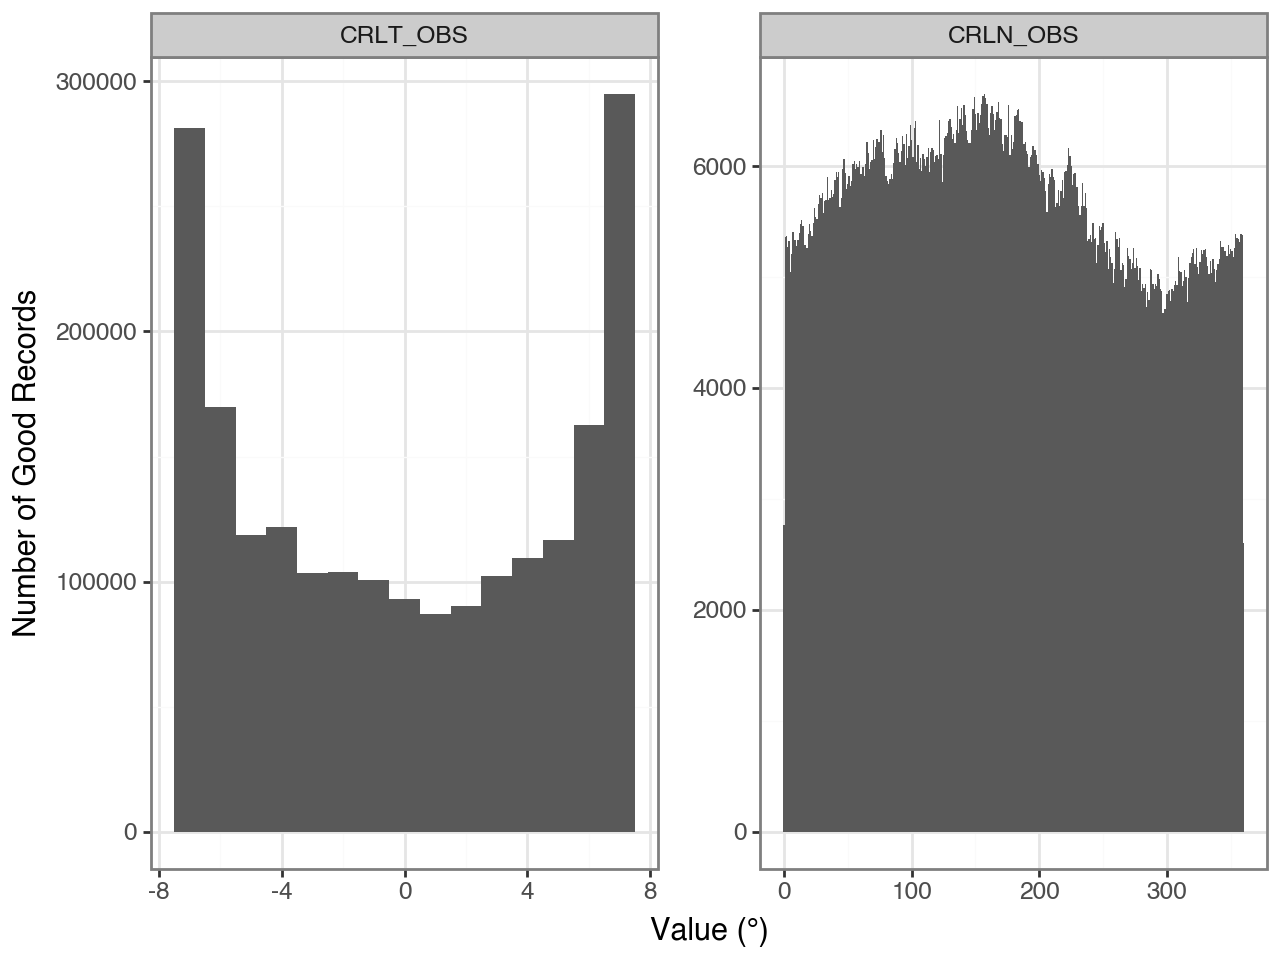

In [6]:
plot_data = (
    all_ars_df
    .query("IS_TMFI & is_complete")
    [["CRLT_OBS", "CRLN_OBS"]]
    .melt(var_name="coord", value_name="val")
)
plot_data["coord"] = pd.Categorical(
    plot_data["coord"], ["CRLT_OBS", "CRLN_OBS"]
)
(
    ggplot(plot_data, aes(x="val")) +
    facet_wrap("coord", scales="free") +
    geom_histogram(binwidth=1) +
    labs(x="Value (°)", y="Number of Good Records") +
    theme_bw()
)

Based on the code [here](https://bitbucket.org/gsudmlab/armvtsprep/src/main/mvts/add_TMFI_column.py),
it seems like `HC_ANGLE` was calculated by setting $B_0 = 0$, by calculating the
Stonyhurst latitude of the AR center as `CRVAL2 - CRLT_OBS`, and by calculating
the Stonyhurst longitude of the AR center as `CRVAL1 - CRLN_OBS`. The code below
confirms this; values agree to within $10^{-11\,\circ}$.

In [7]:
all_ars_df["HC_ANGLE_dup"] = calc_heliocentric_angles(
    B0=0,
    Theta=all_ars_df["CRVAL2"] - all_ars_df["CRLT_OBS"],
    Phi=all_ars_df["CRVAL1"] - all_ars_df["CRLN_OBS"]
)
all_ars_df["orig_equals_dup"] = np.isclose(
    all_ars_df["HC_ANGLE"],
    all_ars_df["HC_ANGLE_dup"],
    rtol=0,
    atol=1e-11,
    equal_nan=True
)

assert all_ars_df["orig_equals_dup"].all()

However, `HC_ANGLE` should have been calculated by setting $B_0$ equal to
`CRLT_OBS` and $\Theta$ to `CRVAL2`. The code below shows that even if we only
look at good records and use a large tolerance of $0.1^{\circ}$, `HC_ANGLE` has
the wrong value for most records.

In [8]:
all_ars_df["HC_ANGLE_right"] = calc_heliocentric_angles(
    B0=all_ars_df["CRLT_OBS"],
    Theta=all_ars_df["CRVAL2"],
    Phi=all_ars_df["CRVAL1"] - all_ars_df["CRLN_OBS"]
)
all_ars_df["orig_equals_right"] = np.isclose(
    all_ars_df["HC_ANGLE"],
    all_ars_df["HC_ANGLE_right"],
    rtol=0,
    atol=0.1,
    equal_nan=True
)
all_ars_df["orig_minus_right"] = all_ars_df["HC_ANGLE"] - \
    all_ars_df["HC_ANGLE_right"]

(
    all_ars_df
    .query("IS_TMFI & is_complete")
    ["orig_equals_right"]
    .value_counts(normalize=True)
)

orig_equals_right
False    0.625415
True     0.374585
Name: proportion, dtype: float64

The histogram below shows that for the good records, the largest differences
between actual and correct values are around $2^{\circ}$ in magnitude, with most
differences being close to $0^{\circ}$.

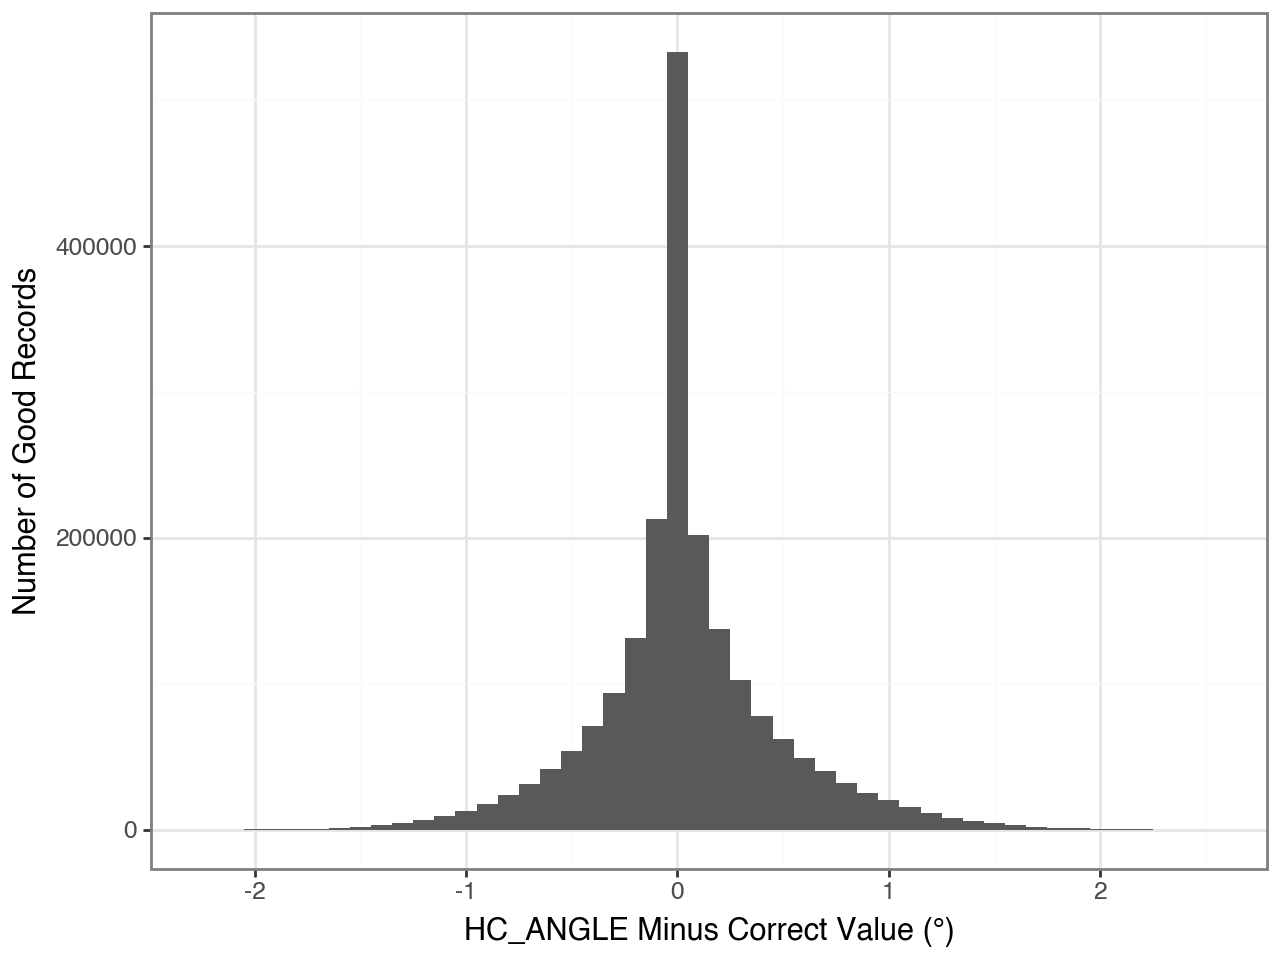

In [9]:
(
    ggplot(
        all_ars_df.query("IS_TMFI & is_complete"), aes(x="orig_minus_right")
    ) +
    geom_histogram(binwidth=0.1) +
    labs(x="HC_ANGLE Minus Correct Value (°)", y="Number of Good Records") +
    theme_bw()
)

If the $y$- and $z$-axes are rotated so that $B_0 = 0$, i.e., so that the
$z$-axis passes through the subobserver point, then both Stonyhurst latitudes
and Stonyhurst longitudes need to be adjusted.

The new Stonyhurst latitude of a point is the angle between the center-to-point
vector and its projection onto the plane spanned by the $x$-axis and the new
$z$-axis.

Let $v \in \mathbb{R}^3$ be the vector and let $Q \in \mathbb{R}^{3 \times 2}$
be a matrix whose columns form an orthonormal basis of the plane. Then the
projection onto the plane is $Q Q^{\top}v$, so the cosine of the new latitude is
$$
\frac{v^{\top}Q Q^{\top}v}{\|v\|_2\|Q Q^{\top}v\|_2}
= \frac{\|Q^{\top}v\|_2^2}{\|v\|_2\|Q^{\top}v\|_2}
= \left\|Q^{\top}\frac{v}{\|v\|_2}\right\|_2.
$$
By $(1)$, the new $z$-axis is parallel to $w := (0, \sin B_0, \cos B_0)$. This
vector and the vector $(1, 0, 0)$ form an orthonormal basis of the plane, so we
have
$$
Q = \left(\begin{matrix} 1 & 0 \\ 0 & \sin B_0 \\ 0 & \cos B_0 \end{matrix}\right).
$$
By $(2)$, $v = (R_{\odot}\cos\Theta\sin\Phi, R_{\odot}\sin\Theta, R_{\odot}\cos\Theta\cos\Phi)$.
Since $\|v\|_2 = R_{\odot}$, we get
$$
\frac{v}{\|v\|_2} = (\cos\Theta\sin\Phi, \sin\Theta, \cos\Theta\cos\Phi).
$$
Hence,
$$
\begin{align*}
Q^{\top}\frac{v}{\|v\|_2}
&= \left(\begin{matrix} 1 & 0 & 0 \\ 0 & \sin B_0 & \cos B_0 \end{matrix}\right)\left(\begin{matrix} \cos\Theta\sin\Phi \\ \sin\Theta \\ \cos\Theta\cos\Phi \end{matrix}\right) \\
&= \left(\begin{matrix} \cos\Theta\sin\Phi \\ \sin B_0\sin\Theta + \cos B_0\cos\Theta\cos\Phi \end{matrix}\right); \\
\left\|Q^{\top}\frac{v}{\|v\|_2}\right\|_2
&= \sqrt{\cos^2\Theta\sin^2\Phi + (\sin B_0\sin\Theta + \cos B_0\cos\Theta\cos\Phi)^2}. \tag{3}
\end{align*}
$$
Expanding the expression inside the square root yields an expression that
doesn't seem like it can be simplified. We can now express the new latitude as
$$
\arccos\sqrt{\cos^2\Theta\sin^2\Phi + (\sin B_0\sin\Theta + \cos B_0\cos\Theta\cos\Phi)^2}, \tag{4}
$$
which doesn't appear to simplify to $\Theta - B_0$, the difference corresponding
to `CRVAL2 - CRLT_OBS`. However, note that when $\Phi = 0$, the new latitude
does simplify to $\Theta - B_0$.

We next compute the new Stonyhurst longitude of the point. This is just the
angle between the projection of $v$ and the vector $w$. The cosine of the angle
is thus
$$
\frac{w^{\top}Q Q^{\top}v}{\|w\|_2\|Q Q^{\top}v\|_2}
= \frac{(Q Q^{\top}w)^{\top}v}{\|Q^{\top}v\|_2}
= \frac{w^{\top}v}{\|Q^{\top}v\|_2},
= \frac{w^{\top}(v / \|v\|_2)}{\|Q^{\top}(v / \|v\|_2)\|_2},
$$
where we used the fact that $w$ is in the plane that $Q Q^{\top}$ projects onto.
We have
$$
w^{\top}(v / \|v\|_2)
= \left(\begin{matrix} 0 & \sin B_0 & \cos B_0 \end{matrix}\right)\left(\begin{matrix} \cos\Theta\sin\Phi \\ \sin\Theta \\ \cos\Theta\cos\Phi\end{matrix}\right)
= \sin B_0\sin\Theta + \cos B_0\cos\Theta\cos\Phi.
$$
It follows from this and $(3)$ that the new longitude is
$$
\arccos\frac{\sin B_0\sin\Theta + \cos B_0\cos\Theta\cos\Phi}{\sqrt{\cos^2\Theta\sin^2\Phi + (\sin B_0\sin\Theta + \cos B_0\cos\Theta\cos\Phi)^2}}. \tag{5}
$$
This doesn't seem to always simplify to $\Phi$, which is the value of
`CRVAL1 - CRLN_OBS`. When $\Phi = 0$, the new longitude is also zero degrees
though.

The following functions uses the formulas in $(4)$ and $(5)$ to calculate the new latitude and longitude.

In [10]:
def calc_new_stonyhurst_lats(
        B0: np.ndarray, Theta: np.ndarray, Phi: np.ndarray
    ) -> np.ndarray:
    B0 = np.deg2rad(B0)
    Theta = np.deg2rad(Theta)
    Phi = np.deg2rad(Phi)

    Q_T_v_unit_0s = np.cos(Theta) * np.sin(Phi)
    Q_T_v_unit_1s = np.sin(B0) * np.sin(Theta) + \
        np.cos(B0) * np.cos(Theta) * np.cos(Phi)
    cosines = np.hypot(Q_T_v_unit_0s, Q_T_v_unit_1s)
    cosines = np.clip(cosines, -1, 1)

    return np.rad2deg(np.arccos(cosines))

def calc_new_stonyhurst_longs(
        B0: np.ndarray, Theta: np.ndarray, Phi: np.ndarray
    ) -> np.ndarray:
    B0 = np.deg2rad(B0)
    Theta = np.deg2rad(Theta)
    Phi = np.deg2rad(Phi)

    numers = np.sin(B0) * np.sin(Theta) + \
        np.cos(B0) * np.cos(Theta) * np.cos(Phi)
    denoms = np.hypot(np.cos(Theta) * np.sin(Phi), numers)
    cosines = np.clip(numers / denoms, -1, 1)

    return np.rad2deg(np.arccos(cosines))

The code below verifies that we can use the new latitudes and longitudes to
calculate the correct values of the heliocentric angle.

In [11]:
all_ars_df["new_Theta"] = calc_new_stonyhurst_lats(
    B0=all_ars_df["CRLT_OBS"],
    Theta=all_ars_df["CRVAL2"],
    Phi=all_ars_df["CRVAL1"] - all_ars_df["CRLN_OBS"]
)
all_ars_df["new_Phi"] = calc_new_stonyhurst_longs(
    B0=all_ars_df["CRLT_OBS"],
    Theta=all_ars_df["CRVAL2"],
    Phi=all_ars_df["CRVAL1"] - all_ars_df["CRLN_OBS"]
)
all_ars_df["HC_ANGLE_right2"] = calc_heliocentric_angles(
    B0=0, Theta=all_ars_df["new_Theta"], Phi=all_ars_df["new_Phi"]
)
all_ars_df["right2_equals_right"] = np.isclose(
    all_ars_df["HC_ANGLE_right"],
    all_ars_df["HC_ANGLE_right2"],
    rtol=0,
    atol=1e-11,
    equal_nan=True
)

assert all_ars_df["right2_equals_right"].all()